# IMU Dataset Preprocessing

This notebook performs a full quality audit and preprocessing pass on the dataset stored in
`/home/zohaib/Downloads/IMU_Dataset/Dataset/Overall_samples`. The goal is to convert raw IMU trials into a
clean, fixed-length tensor suitable for training deep learning models.

**Pipeline steps (clear names):**
1. Data discovery
2. Cleaning (robust CSV loading)
2b. Cleaning audit (row-level checks)
3. Distribution check (per digit, per user)
4. Sampling rate check
5. Raw signal preview
6. Time alignment + Resampling + Fixed-length sequences + Label encoding (+ optional smoothing)
7. Feature scaling (train-only) + Train/Val/Test split (required) + save outputs
8. Final sanity plot

Outputs written to `Dataset/preprocessed/`:
- `splits.npz` (train/val/test indices)
- `train/data.npz`, `val/data.npz`, `test/data.npz` (X_raw, X_scaled, y, indices, feature_mean, feature_std)
- `train/metadata.csv`, `val/metadata.csv`, `test/metadata.csv` (per-sample metadata)


In [1]:
from pathlib import Path
import csv
import json
import math
import random
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt

# Reproducibility for any random operations
random.seed(42)
np.random.seed(42)

# Toggle for verbose debugging output
DEBUG = True

def debug(msg):
    if DEBUG:
        print(f"DEBUG: {msg}")

# Base folder that contains Overall_samples and preprocessed outputs
DATASET_BASE = Path("/home/zohaib/Downloads/IMU_Dataset/Dataset")
if not DATASET_BASE.exists():
    DATASET_BASE = Path.cwd()

# Raw input root (auto-detect Overall_samples if present)
RAW_ROOT = DATASET_BASE / "Overall_samples"
if not RAW_ROOT.exists():
    RAW_ROOT = DATASET_BASE

# Output folder for preprocessed files (kept at Dataset/preprocessed)
OUTPUT_DIR = DATASET_BASE / "preprocessed"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

debug(f"Dataset base: {DATASET_BASE}")
debug(f"Raw data root: {RAW_ROOT}")
debug(f"Output dir: {OUTPUT_DIR}")


DEBUG: Dataset base: /home/zohaib/Downloads/IMU_Dataset/Dataset
DEBUG: Raw data root: /home/zohaib/Downloads/IMU_Dataset/Dataset/Overall_samples
DEBUG: Output dir: /home/zohaib/Downloads/IMU_Dataset/Dataset/preprocessed


## Step 1: Data discovery (what files exist?)
We scan **all subfolders recursively** under `Overall_samples` to find trials.
A trial is any folder that contains both `Accelerometer.csv` and `Gyroscope.csv`.

**Folder naming rule (important):**
- `P1,0,1` means **Phone/User 1**, **Digit 0**, **Try 1**

Labels are detected in two ways:
- From the folder name (e.g., `P1,0,100` → user=1, digit=0, try=100)
- From parent folders (e.g., `User 1 Digit 0` in a nested layout)

**Note:** Think of this step as building an index of all valid examples so
we know exactly what data we have before doing any processing.


In [2]:
# Collect trial directories and basic metadata
records = []
missing = []
trial_dirs = []
invalid_labels = []
duplicate_trials = 0

# Helper: parse user, digit, try from flat trial folder name like "P1,0,100"
def parse_trial_name(name):
    parts = name.split(",")
    if len(parts) < 2:
        return None, None, None
    user_id = parts[0].lstrip("P")
    digit = parts[1]
    try_id = parts[2] if len(parts) > 2 else None
    return user_id, digit, try_id

# Helper: parse user/digit from any parent path parts like "User 1" and "Digit 0"
def parse_from_path(path):
    user_id = None
    digit = None
    for part in path.parts:
        if part.startswith("User "):
            user_id = part.replace("User", "").strip()
        if "Digit" in part:
            after = part.split("Digit")[-1].strip()
            if after.isdigit():
                digit = after
    return user_id, digit

# Scan recursively for Accelerometer.csv files
acc_files = list(RAW_ROOT.rglob("Accelerometer.csv"))
debug(f"Recursive scan: found {len(acc_files)} Accelerometer.csv files")

seen_trials = set()
for acc_path in acc_files:
    trial_dir = acc_path.parent
    gyro_path = trial_dir / "Gyroscope.csv"

    if not gyro_path.exists():
        missing.append(trial_dir)
        continue

    if trial_dir in seen_trials:
        duplicate_trials += 1
        continue
    seen_trials.add(trial_dir)
    trial_dirs.append(trial_dir)

    # Try parsing labels from the trial folder name first
    user_id, digit, try_id = parse_trial_name(trial_dir.name)

    # If not found, try parsing from parent folders (nested layout)
    if user_id is None or digit is None:
        user_id, digit = parse_from_path(trial_dir)

    if user_id is None or digit is None:
        invalid_labels.append(trial_dir)
        continue

    try:
        digit_val = int(digit)
    except ValueError:
        invalid_labels.append(trial_dir)
        continue

    records.append({
        "user_id": user_id,
        "digit": digit_val,
        "try_id": try_id,
        "trial_id": trial_dir.name,
        "acc_path": acc_path,
        "gyro_path": gyro_path,
        "trial_dir": trial_dir,
    })

debug(f"Found trial dirs with both sensors: {len(trial_dirs)}")
debug(f"Usable trials: {len(records)}")
debug(f"Missing sensor files: {len(missing)}")
debug(f"Invalid label folders: {len(invalid_labels)}")
debug(f"Duplicate trial dirs skipped: {duplicate_trials}")


DEBUG: Recursive scan: found 686 Accelerometer.csv files
DEBUG: Found trial dirs with both sensors: 686
DEBUG: Usable trials: 686
DEBUG: Missing sensor files: 0
DEBUG: Invalid label folders: 0
DEBUG: Duplicate trial dirs skipped: 0


## Step 2: Cleaning (robust CSV loading + basic stats)
We clean every CSV file while reading it:
- Remove empty rows
- Skip rows with missing columns
- Skip non-numeric or non-finite values (NaN/Inf)
- Sort by time and remove duplicate timestamps

We also compute basic statistics (sample rate, overlap duration, sample counts) to
understand data quality.

Cleaning ensures the model does not learn from broken or messy data.


In [3]:
# Detect delimiter for a given CSV (comma or tab)
def sniff_delimiter(path):
    with path.open("r", newline="") as f:
        line = f.readline()
    if "	" in line and line.count("	") >= line.count(","):
        return "	"
    return ","


# Load a sensor CSV robustly and return time + 3-axis values
# This is where **cleaning** happens: invalid rows are skipped and duplicates removed.
def read_sensor_csv(path, return_delim=False):
    delim = sniff_delimiter(path)
    times = []
    values = []

    with path.open("r", newline="") as f:
        reader = csv.reader(f, delimiter=delim)
        header = next(reader, None)
        for row in reader:
            if not row:
                continue
            # Fallback for lines read as one tab-delimited string
            if len(row) == 1 and "	" in row[0]:
                row = row[0].split("	")
            if len(row) < 4:
                continue
            try:
                t = float(row[0])
                v = [float(row[1]), float(row[2]), float(row[3])]
            except Exception:
                continue
            times.append(t)
            values.append(v)

    if not times:
        if return_delim:
            return np.array([]), np.empty((0, 3)), delim
        return np.array([]), np.empty((0, 3))

    time_arr = np.array(times, dtype=float)
    val_arr = np.array(values, dtype=float)

    # Remove non-finite values
    mask = np.isfinite(time_arr) & np.all(np.isfinite(val_arr), axis=1)
    time_arr = time_arr[mask]
    val_arr = val_arr[mask]

    # Sort by time and drop duplicates
    order = np.argsort(time_arr)
    time_arr = time_arr[order]
    val_arr = val_arr[order]
    if time_arr.size > 1:
        unique_mask = np.concatenate([[True], np.diff(time_arr) != 0])
        time_arr = time_arr[unique_mask]
        val_arr = val_arr[unique_mask]

    if return_delim:
        return time_arr, val_arr, delim
    return time_arr, val_arr


# Compute per-trial statistics for sampling rate and duration
valid_records = []
stats = []

delim_counts = Counter()
bad_records = []

for rec in records:
    acc_time, acc_vals, acc_delim = read_sensor_csv(rec["acc_path"], return_delim=True)
    gyro_time, gyro_vals, gyro_delim = read_sensor_csv(rec["gyro_path"], return_delim=True)

    delim_counts[acc_delim] += 1
    delim_counts[gyro_delim] += 1

    # Skip empty or unusable trials
    if acc_time.size < 2 or gyro_time.size < 2:
        bad_records.append(rec)
        continue

    # Median sampling interval (seconds)
    acc_dt = float(np.median(np.diff(acc_time)))
    gyro_dt = float(np.median(np.diff(gyro_time)))

    # Overlap duration where both sensors have data
    t_start = max(acc_time.min(), gyro_time.min())
    t_end = min(acc_time.max(), gyro_time.max())
    duration = float(t_end - t_start)

    rec_stats = {
        "user_id": rec["user_id"],
        "digit": rec["digit"],
        "trial_id": rec["trial_id"],
        "acc_len": int(acc_time.size),
        "gyro_len": int(gyro_time.size),
        "acc_dt": acc_dt,
        "gyro_dt": gyro_dt,
        "duration": duration,
    }
    rec["stats"] = rec_stats

    stats.append(rec_stats)
    valid_records.append(rec)

records = valid_records

debug(f"Bad or empty records skipped: {len(bad_records)}")
debug(f"Delimiter counts: {dict(delim_counts)}")

acc_dts = [s["acc_dt"] for s in stats]
gyro_dts = [s["gyro_dt"] for s in stats]
durations = [s["duration"] for s in stats]

debug(f"acc dt median: {np.median(acc_dts):.6f} (rate {1/np.median(acc_dts):.2f} Hz)")
debug(f"gyro dt median: {np.median(gyro_dts):.6f} (rate {1/np.median(gyro_dts):.2f} Hz)")
debug(f"duration median: {np.median(durations):.3f}s | min: {np.min(durations):.3f}s | max: {np.max(durations):.3f}s")


DEBUG: Bad or empty records skipped: 0
DEBUG: Delimiter counts: {',': 1370, '\t': 2}
DEBUG: acc dt median: 0.010051 (rate 99.49 Hz)
DEBUG: gyro dt median: 0.010051 (rate 99.49 Hz)
DEBUG: duration median: 2.655s | min: 1.266s | max: 11.285s


## Step 2b: Cleaning audit (row-level checks)
This is a full health check. If any file has bad rows, it will be listed. We read every row in every CSV to confirm data quality. This reports:
- Total rows vs valid rows
- Missing columns, non-numeric rows, or non-finite values
- Duplicate timestamps or time-order problems

**Plot explanation (Valid row counts per file):**
- Two histograms are shown: one for accelerometer files and one for gyroscope files.
- Each bar shows how many files have a certain number of valid rows.
- If both histograms overlap tightly, the sensors have similar record lengths.




Processed 100/1372 files in 0.1s
Processed 200/1372 files in 0.3s
Processed 300/1372 files in 0.4s
Processed 400/1372 files in 0.5s
Processed 500/1372 files in 0.6s
Processed 600/1372 files in 0.7s
Processed 700/1372 files in 0.8s
Processed 800/1372 files in 0.9s
Processed 900/1372 files in 1.0s
Processed 1000/1372 files in 1.1s
Processed 1100/1372 files in 1.2s
Processed 1200/1372 files in 1.3s
Processed 1300/1372 files in 1.4s
Row-level audit summary:
  files: 1372
  rows_total: 370799
  rows_valid: 370799
  rows_missing_cols: 0
  rows_non_numeric: 0
  rows_non_finite: 0
  rows_empty: 0
  time_non_monotonic: 0
  time_duplicates: 0
  rows_invalid: 0

Worst files by invalid rows: none (all files have 0 invalid rows)


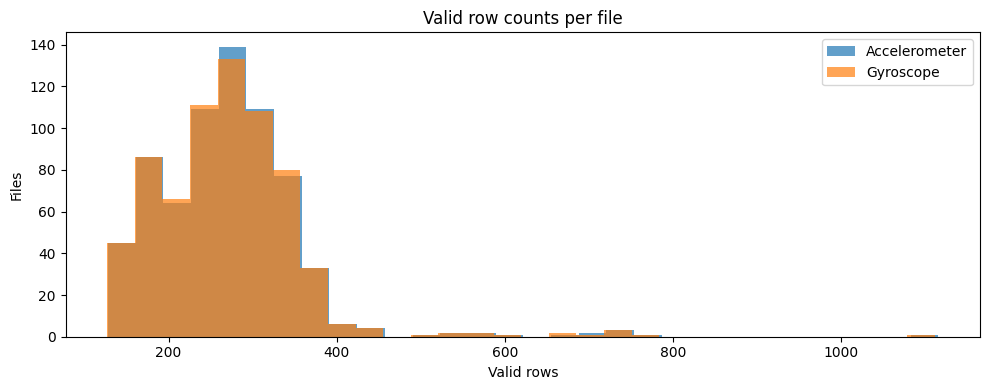

In [4]:
# Full row-level audit to detect any data quality issues
import time

# Set LIMIT_FILES to a positive integer to test quickly; keep None for full scan
LIMIT_FILES = None
SHOW_PROGRESS = True
PROGRESS_EVERY = 100

def audit_csv(path, sensor_label):
    delim = sniff_delimiter(path)
    total = 0
    valid = 0
    missing_cols = 0
    non_numeric = 0
    non_finite = 0
    empty_rows = 0
    times = []

    with path.open("r", newline="") as f:
        reader = csv.reader(f, delimiter=delim)
        header = next(reader, None)
        if header is None:
            return {
                "sensor": sensor_label,
                "path": str(path),
                "total_rows": 0,
                "valid_rows": 0,
                "missing_cols": 0,
                "non_numeric": 0,
                "non_finite": 0,
                "empty_rows": 0,
                "time_non_monotonic": 0,
                "time_duplicates": 0,
                "time_min": None,
                "time_max": None,
            }

        for row in reader:
            total += 1
            if not row or all(str(cell).strip() == "" for cell in row):
                empty_rows += 1
                continue
            if len(row) == 1 and "	" in row[0]:
                row = row[0].split("	")
            if len(row) < 4:
                missing_cols += 1
                continue
            try:
                t = float(row[0])
                v1 = float(row[1])
                v2 = float(row[2])
                v3 = float(row[3])
            except Exception:
                non_numeric += 1
                continue

            if not np.isfinite(t) or not np.isfinite(v1) or not np.isfinite(v2) or not np.isfinite(v3):
                non_finite += 1
                continue

            valid += 1
            times.append(t)

    # Time order checks
    time_non_monotonic = 0
    time_duplicates = 0
    time_min = None
    time_max = None
    if len(times) > 1:
        times_arr = np.array(times, dtype=float)
        time_min = float(times_arr.min())
        time_max = float(times_arr.max())
        diffs = np.diff(times_arr)
        time_non_monotonic = int(np.sum(diffs < 0))
        time_duplicates = int(np.sum(diffs == 0))
    elif len(times) == 1:
        time_min = float(times[0])
        time_max = float(times[0])

    return {
        "sensor": sensor_label,
        "path": str(path),
        "total_rows": total,
        "valid_rows": valid,
        "missing_cols": missing_cols,
        "non_numeric": non_numeric,
        "non_finite": non_finite,
        "empty_rows": empty_rows,
        "time_non_monotonic": time_non_monotonic,
        "time_duplicates": time_duplicates,
        "time_min": time_min,
        "time_max": time_max,
    }


file_stats = []
summary = {
    "files": 0,
    "rows_total": 0,
    "rows_valid": 0,
    "rows_missing_cols": 0,
    "rows_non_numeric": 0,
    "rows_non_finite": 0,
    "rows_empty": 0,
    "time_non_monotonic": 0,
    "time_duplicates": 0,
}

start_time = time.time()

# Build a list of files to audit
sensor_files = []
for rec in records:
    sensor_files.append(("acc", rec["acc_path"]))
    sensor_files.append(("gyro", rec["gyro_path"]))

if LIMIT_FILES is not None:
    sensor_files = sensor_files[:LIMIT_FILES]

for idx, (sensor_label, path) in enumerate(sensor_files, start=1):
    stats_row = audit_csv(path, sensor_label)
    file_stats.append(stats_row)
    summary["files"] += 1
    summary["rows_total"] += stats_row["total_rows"]
    summary["rows_valid"] += stats_row["valid_rows"]
    summary["rows_missing_cols"] += stats_row["missing_cols"]
    summary["rows_non_numeric"] += stats_row["non_numeric"]
    summary["rows_non_finite"] += stats_row["non_finite"]
    summary["rows_empty"] += stats_row["empty_rows"]
    summary["time_non_monotonic"] += stats_row["time_non_monotonic"]
    summary["time_duplicates"] += stats_row["time_duplicates"]

    if SHOW_PROGRESS and (idx % PROGRESS_EVERY == 0):
        elapsed = time.time() - start_time
        print(f"Processed {idx}/{len(sensor_files)} files in {elapsed:.1f}s")

summary["rows_invalid"] = summary["rows_total"] - summary["rows_valid"]

print("Row-level audit summary:")
for k, v in summary.items():
    print(f"  {k}: {v}")

# Show top 10 files with highest invalid rows

def invalid_count(s):
    return s["total_rows"] - s["valid_rows"]

invalid_files = [r for r in file_stats if invalid_count(r) > 0]
print("")
if invalid_files:
    worst = sorted(invalid_files, key=invalid_count, reverse=True)[:10]
    print("Worst files by invalid rows:")
    for row in worst:
        invalid_rows = invalid_count(row)
        print(
            f"{row['sensor']} | {row['path']} | invalid={invalid_rows} | total={row['total_rows']} | valid={row['valid_rows']} | "
            f"missing_cols={row['missing_cols']} | non_numeric={row['non_numeric']} | "
            f"non_finite={row['non_finite']} | empty={row['empty_rows']}"
        )
else:
    print("Worst files by invalid rows: none (all files have 0 invalid rows)")

# Plot distribution of valid row counts
acc_counts = [r["valid_rows"] for r in file_stats if r["sensor"] == "acc"]
gyro_counts = [r["valid_rows"] for r in file_stats if r["sensor"] == "gyro"]

plt.figure(figsize=(10, 4))
plt.hist(acc_counts, bins=30, alpha=0.7, label="Accelerometer")
plt.hist(gyro_counts, bins=30, alpha=0.7, label="Gyroscope")
plt.title("Valid row counts per file")
plt.xlabel("Valid rows")
plt.ylabel("Files")
plt.legend()
plt.tight_layout()
plt.show()


## Step 3: Distribution check (counts per digit and user)
We verify how many samples exist for each digit and each user. This helps identify
class imbalance (e.g., too many 0s and too few 9s). Balanced classes are important so the model does not become biased.

**Plot explanation:**
- Left plot: bar chart of total samples for each digit (0-9).
- Right plot: heatmap of counts per user and digit (numbers shown inside each cell).



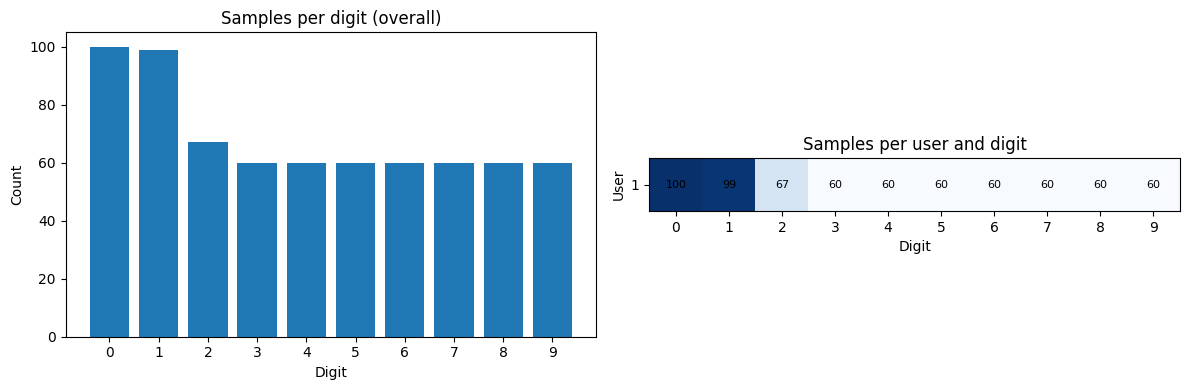

In [5]:
# Count by digit and by user
users = sorted({s["user_id"] for s in stats})
digits = list(range(10))

count_matrix = np.zeros((len(users), len(digits)), dtype=int)
for s in stats:
    u_idx = users.index(s["user_id"])
    d_idx = digits.index(s["digit"])
    count_matrix[u_idx, d_idx] += 1

# Overall digit counts
overall_digit_counts = count_matrix.sum(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(digits, overall_digit_counts)
axes[0].set_title("Samples per digit (overall)")
axes[0].set_xlabel("Digit")
axes[0].set_ylabel("Count")
axes[0].set_xticks(digits)

# Heatmap: user vs digit counts
im = axes[1].imshow(count_matrix, cmap="Blues")
axes[1].set_title("Samples per user and digit")
axes[1].set_xlabel("Digit")
axes[1].set_ylabel("User")
axes[1].set_xticks(range(len(digits)))
axes[1].set_xticklabels(digits)
axes[1].set_yticks(range(len(users)))
axes[1].set_yticklabels(users)

# Annotate counts for readability
for i in range(len(users)):
    for j in range(len(digits)):
        axes[1].text(j, i, str(count_matrix[i, j]), ha="center", va="center", fontsize=8)

plt.tight_layout()
plt.show()


## Step 4: Sampling rate check (how fast data was recorded)
We plot histograms of the sampling intervals (time between readings) and the overlap
length of each trial. This shows whether sensors were recorded consistently. If sampling rates vary too much, resampling is needed.

**Plot explanation:**
- Left: accelerometer sampling interval (dt) distribution.
- Middle: gyroscope sampling interval (dt) distribution.
- Right: overlap duration (seconds) where both sensors have data.



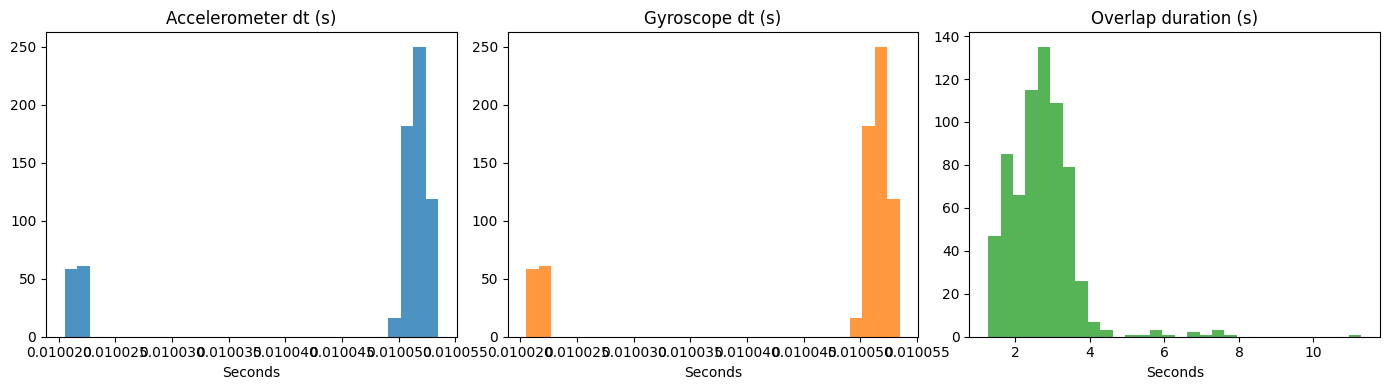

In [6]:
# Histograms of sampling intervals and overlap duration
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(acc_dts, bins=30, color="tab:blue", alpha=0.8)
axes[0].set_title("Accelerometer dt (s)")
axes[0].set_xlabel("Seconds")

axes[1].hist(gyro_dts, bins=30, color="tab:orange", alpha=0.8)
axes[1].set_title("Gyroscope dt (s)")
axes[1].set_xlabel("Seconds")

axes[2].hist(durations, bins=30, color="tab:green", alpha=0.8)
axes[2].set_title("Overlap duration (s)")
axes[2].set_xlabel("Seconds")

plt.tight_layout()
plt.show()


## Step 5: Raw signal preview (quick visual sanity check)
We plot one example per digit to see the motion patterns before any processing. 
This helps confirm the data actually looks like a digit-writing motion.

**Plot explanation:**
- 10 subplots (digits 0-9).
- Each subplot shows two lines: accelerometer magnitude and gyroscope magnitude.
- The x-axis is time (seconds) and the y-axis is signal magnitude.




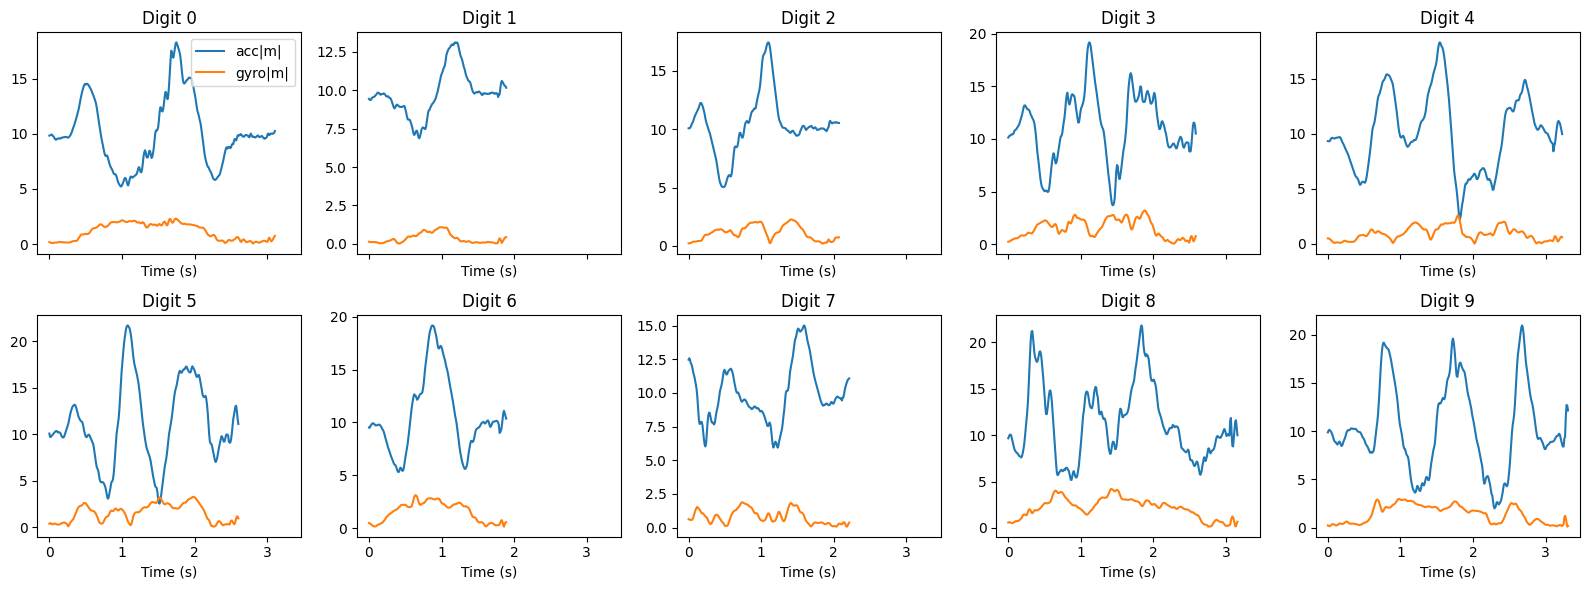

In [7]:
# Pick one sample per digit for visualization
example_by_digit = {}
for rec in records:
    d = rec["digit"]
    if d not in example_by_digit:
        example_by_digit[d] = rec

# Helper: vector magnitude

def magnitude(arr):
    return np.sqrt((arr ** 2).sum(axis=1))

fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=True, sharey=False)
axes = axes.flatten()

for i, d in enumerate(sorted(example_by_digit.keys())):
    rec = example_by_digit[d]
    acc_time, acc_vals = read_sensor_csv(rec["acc_path"])
    gyro_time, gyro_vals = read_sensor_csv(rec["gyro_path"])

    # Align by overlap for fair comparison
    t_start = max(acc_time.min(), gyro_time.min())
    t_end = min(acc_time.max(), gyro_time.max())
    mask_acc = (acc_time >= t_start) & (acc_time <= t_end)
    mask_gyro = (gyro_time >= t_start) & (gyro_time <= t_end)

    acc_mag = magnitude(acc_vals[mask_acc])
    gyro_mag = magnitude(gyro_vals[mask_gyro])

    axes[i].plot(acc_time[mask_acc] - t_start, acc_mag, label="acc|m|")
    axes[i].plot(gyro_time[mask_gyro] - t_start, gyro_mag, label="gyro|m|")
    axes[i].set_title(f"Digit {d}")
    axes[i].set_xlabel("Time (s)")

axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()


## Step 6: Time alignment + Resampling + Fixed-Length Sequences + Label Encoding
This is the core preprocessing pipeline:
- **Time alignment:** find the overlap window between sensors and shift time to start at 0 for each sequence
- **Resampling:** linear interpolation (np.interp) onto a uniform time grid
- **Fixed-Length Sequences:** every trial becomes exactly `TARGET_LEN` time steps
- **Optional Smoothing:** moving average to reduce high-frequency noise
- **Label Encoding:** map digit labels to integer IDs (0–9)

The output is a tensor of shape `[N, T, F]` where `F = 6` (ax, ay, az, gx, gy, gz), plus an integer label vector `y`.

**Important:** Feature scaling (mean/std) happens in Step 7 and is computed from the training split only.

**Beginner note:** Machine learning models need every sample to have the same length,
so we resample each time-series into a fixed-size matrix.


In [8]:
# Fixed-length resampling parameters
TARGET_LEN = 200  # time steps per sample
MIN_DURATION = 0.5  # skip samples with too little overlap

# Optional smoothing (moving average) after resampling
USE_MOVING_AVG = True
MOVING_AVG_WINDOW = 5  # odd number recommended (e.g., 3, 5, 7)


def apply_moving_average(features, window):
    """Smooth each feature using a simple moving average."""
    if window <= 1:
        debug("Moving average disabled (window <= 1)")
        return features
    # Ensure window is odd for symmetric smoothing
    if window % 2 == 0:
        debug(f"Moving average window {window} is even; incrementing to {window + 1}")
        window += 1
    pad = window // 2
    kernel = np.ones(window, dtype=float) / window

    padded = np.pad(features, ((pad, pad), (0, 0)), mode="edge")
    smoothed = np.vstack([
        np.convolve(padded[:, i], kernel, mode="valid")
        for i in range(features.shape[1])
    ]).T
    return smoothed


def align_and_resample(acc_time, acc_vals, gyro_time, gyro_vals, target_len):
    # 1) Time alignment: use overlap window and shift start to 0 seconds
    t_start = max(acc_time.min(), gyro_time.min())
    t_end = min(acc_time.max(), gyro_time.max())
    if t_end <= t_start:
        return None

    duration = t_end - t_start
    if duration < MIN_DURATION:
        return None

    # Keep only the overlap region, then shift time so each sequence starts at 0
    acc_mask = (acc_time >= t_start) & (acc_time <= t_end)
    gyro_mask = (gyro_time >= t_start) & (gyro_time <= t_end)

    acc_time = acc_time[acc_mask] - t_start
    acc_vals = acc_vals[acc_mask]
    gyro_time = gyro_time[gyro_mask] - t_start
    gyro_vals = gyro_vals[gyro_mask]

    # 2) Resampling: fixed-length sequence using linear interpolation
    t_uniform = np.linspace(0.0, duration, target_len)

    acc_interp = np.vstack([
        np.interp(t_uniform, acc_time, acc_vals[:, i])
        for i in range(3)
    ]).T
    gyro_interp = np.vstack([
        np.interp(t_uniform, gyro_time, gyro_vals[:, i])
        for i in range(3)
    ]).T

    # Concatenate features: [ax, ay, az, gx, gy, gz]
    features = np.hstack([acc_interp, gyro_interp])

    # Optional smoothing
    if USE_MOVING_AVG:
        features = apply_moving_average(features, MOVING_AVG_WINDOW)

    return t_uniform, features


X_list = []
y_list = []
meta_rows = []

skipped = 0

# Debug counters
interp_debug_printed = False
alignment_debug_printed = False
smoothing_debug_printed = False

for rec in records:
    # Cleaned time-series from Step 2
    acc_time, acc_vals = read_sensor_csv(rec["acc_path"])
    gyro_time, gyro_vals = read_sensor_csv(rec["gyro_path"])

    # Resample to fixed length with time alignment
    result = align_and_resample(acc_time, acc_vals, gyro_time, gyro_vals, TARGET_LEN)
    if result is None:
        skipped += 1
        continue

    t_uniform, features = result
    X_list.append(features)
    y_list.append(rec["digit"])

    if not alignment_debug_printed:
        debug("Time alignment: overlap start shifted to 0 seconds per sequence")
        alignment_debug_printed = True

    if not interp_debug_printed:
        debug(f"Resampling: linear interpolation to fixed length (TARGET_LEN={TARGET_LEN})")
        debug(f"Resampling time range: 0 to {t_uniform[-1]:.4f} seconds")
        interp_debug_printed = True

    if USE_MOVING_AVG and not smoothing_debug_printed:
        debug(f"Moving average enabled: window={MOVING_AVG_WINDOW}")
        smoothing_debug_printed = True

    # Save per-trial metadata for traceability
    meta_rows.append({
        "user_id": rec["user_id"],
        "digit": rec["digit"],
        "try_id": rec.get("try_id"),
        "trial_id": rec["trial_id"],
        "duration": rec["stats"]["duration"],
        "acc_len": rec["stats"]["acc_len"],
        "gyro_len": rec["stats"]["gyro_len"],
    })

debug(f"Skipped due to short overlap: {skipped}")

debug(f"Samples after resampling: {len(X_list)}")

# Stack into a single tensor [N, T, F]
X = np.stack(X_list, axis=0)
y_raw = np.array(y_list, dtype=int)

# 4) Label encoding: map digits to 0..9
unique_labels = sorted(set(y_raw.tolist()))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y = np.array([label_map[v] for v in y_raw], dtype=int)

debug(f"Label encoding map: {label_map}")

debug(f"X shape: {X.shape} | y shape: {y.shape}")


DEBUG: Time alignment: overlap start shifted to 0 seconds per sequence
DEBUG: Resampling: linear interpolation to fixed length (TARGET_LEN=200)
DEBUG: Resampling time range: 0 to 1.8895 seconds
DEBUG: Moving average enabled: window=5
DEBUG: Skipped due to short overlap: 0
DEBUG: Samples after resampling: 686
DEBUG: Label encoding map: {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
DEBUG: X shape: (686, 200, 6) | y shape: (686,)


## Step 7: Feature scaling (train-only) + Train/Val/Test split (required) + create folders
We create stratified indices so each digit appears in training, validation, and test
sets in similar proportions.

**Feature scaling (required):**
- Compute mean and standard deviation from the **training split only**.
- Apply the same scaling to train, validation, and test sets.
- This avoids data leakage and keeps evaluation fair.

Folders created under `Dataset/preprocessed/`:
- `train/` (training samples)
- `val/` (validation samples)
- `test/` (test samples)

Each folder contains:
- `data.npz` (X_raw, X_scaled, y, indices, feature_mean, feature_std)
- `metadata.csv` (per-sample metadata)

**Note:** The test set must stay untouched until the final evaluation.


In [9]:
# Stratified split (required) keeps class balance across digits

def stratified_split(labels, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    rng = np.random.default_rng(seed)
    labels = np.asarray(labels)

    train_idx = []
    val_idx = []
    test_idx = []

    for digit in sorted(set(labels.tolist())):
        idx = np.where(labels == digit)[0]
        rng.shuffle(idx)
        n = len(idx)

        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)
        n_test = n - n_train - n_val

        # Ensure at least 1 sample in each split (if possible)
        if n_test == 0 and n > 2:
            n_test = 1
            n_train -= 1
        if n_val == 0 and n > 2:
            n_val = 1
            n_train -= 1

        train_idx.extend(idx[:n_train])
        val_idx.extend(idx[n_train:n_train + n_val])
        test_idx.extend(idx[n_train + n_val:])

    return np.array(train_idx), np.array(val_idx), np.array(test_idx)


train_idx, val_idx, test_idx = stratified_split(y)

debug(f"Train: {len(train_idx)} | Val: {len(val_idx)} | Test: {len(test_idx)}")

# 3) Feature scaling: compute mean/std from training set only
feature_mean = X[train_idx].mean(axis=(0, 1))
feature_std = X[train_idx].std(axis=(0, 1))
feature_std[feature_std == 0] = 1.0

X_scaled = (X - feature_mean) / feature_std

debug("Feature scaling: mean/std computed from training set only")

# Save split indices (for reproducibility)
split_path = OUTPUT_DIR / "splits.npz"
np.savez(split_path, train_idx=train_idx, val_idx=val_idx, test_idx=test_idx)
print(f"Saved: {split_path}")

# Create split folders if they do not exist and save data
split_map = {
    "train": train_idx,
    "val": val_idx,
    "test": test_idx,
}

# Ensure meta_rows is available and ordered consistently with X/y
if not meta_rows:
    raise ValueError("meta_rows is empty; run Step 6 before Step 8")

meta_fields = list(meta_rows[0].keys())

for split_name, idx in split_map.items():
    split_dir = OUTPUT_DIR / split_name
    split_dir.mkdir(parents=True, exist_ok=True)

    # Save arrays for this split
    np.savez(
        split_dir / "data.npz",
        X_raw=X[idx],
        X_scaled=X_scaled[idx],
        y=y[idx],
        indices=idx,
        feature_mean=feature_mean,
        feature_std=feature_std,
    )

    # Save metadata rows for this split
    meta_path = split_dir / "metadata.csv"
    with meta_path.open("w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=meta_fields)
        writer.writeheader()
        for i in idx:
            writer.writerow(meta_rows[i])

print("Split folders created/updated:")
print(f"- {OUTPUT_DIR / 'train'}")
print(f"- {OUTPUT_DIR / 'val'}")
print(f"- {OUTPUT_DIR / 'test'}")


DEBUG: Train: 548 | Val: 67 | Test: 71
DEBUG: Feature scaling: mean/std computed from training set only
Saved: /home/zohaib/Downloads/IMU_Dataset/Dataset/preprocessed/splits.npz
Split folders created/updated:
- /home/zohaib/Downloads/IMU_Dataset/Dataset/preprocessed/train
- /home/zohaib/Downloads/IMU_Dataset/Dataset/preprocessed/val
- /home/zohaib/Downloads/IMU_Dataset/Dataset/preprocessed/test


## Step 8: Final sanity plot
We plot one standardized sample to confirm the shape and scaling are correct.

**Plot explanation:**
- The plot contains 6 lines (ax, ay, az, gx, gy, gz) after normalization.
- Values should be centered roughly around 0 with similar scale.

**Note:** This is a quick final check before training.


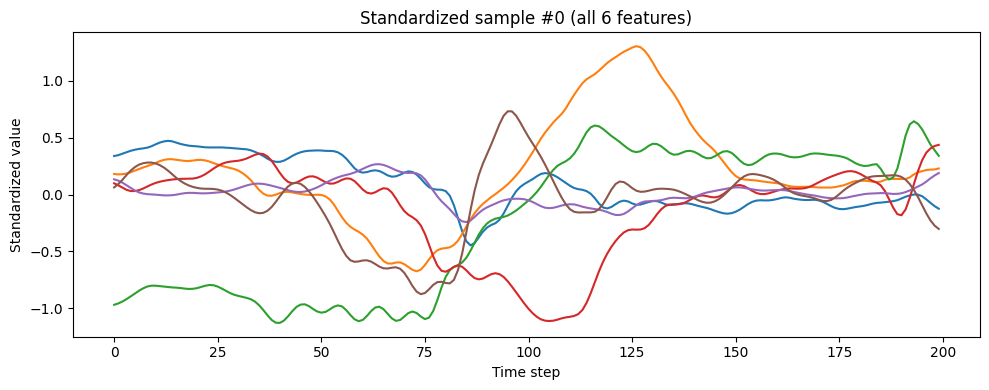

In [10]:
# Plot one standardized sample to verify shape and scaling
sample_idx = 0
sample = X_scaled[sample_idx]

plt.figure(figsize=(10, 4))
plt.plot(sample)
plt.title(f"Standardized sample #{sample_idx} (all 6 features)")
plt.xlabel("Time step")
plt.ylabel("Standardized value")
plt.tight_layout()
plt.show()
